In [2]:
#Libraries

import numpy as np
import pandas as pd
import scanpy as sc
import h5py
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import random

In [2]:
def clean_data(data_10x, treatments):
    data = sc.read_10x_h5(data_10x)
    data.var_names_make_unique()
    treatment_barcodes = pd.read_table(treatments, header=None)
    data.obs['treatment'] = np.array(treatment_barcodes[2])
    sc.pp.filter_cells(data, min_genes = 200)
    sc.pp.filter_genes(data, min_cells = 3)
    sc.pp.normalize_total(data, target_sum=1e3)
    sc.pp.log1p(data)
    sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=.5)
    data = data[:, data.var.highly_variable]
    sc.pp.scale(data, max_value=10)
    return data

In [3]:
class BIOF509_A_Final:
    
    
    def __init__(self,data):
        self.data = data.X

        
    class Autoencoder(nn.Module):
        
        def __init__(self,data_length,hidden_dimension,bottleneck_dimension):
    
            super(BIOF509_A_Final.Autoencoder, self).__init__()

            self.encoder = nn.Sequential(
            nn.Linear(data_length,hidden_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dimension,bottleneck_dimension))
            
            self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dimension,hidden_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dimension,data_length),
            nn.Tanh())
            
            
        def forward(self, batch):
            batch = self.encoder(batch)
            batch = self.decoder(batch)
            return batch
        
        
    def train_test(self,hidden_dimension,bottleneck_size,batch_size,n_epochs,lr):
            
 
            batches = batchify_autoencoder(self.data,batch_size=batch_size)
            neural_network = BIOF509_A_Final.Autoencoder(len(np.ravel(self.data[0])),hidden_dimension,bottleneck_size)
            optimizer = optim.SGD(neural_network.parameters(), lr=0.01)
            loss_function = nn.MSELoss()
            neural_network.train()
        
            for i in range(n_epochs):
                error = 0
                for ii in range(len(batches)):
                
                    optimizer.zero_grad()
                
                    batch = batches[ii]

                    predictions = neural_network(torch.tensor(np.asarray(batch).astype(np.float32)))
                    
                    ### input the predicted data and the original data into the MSE loss function
                    loss = loss_function(predictions,torch.tensor(np.asarray(batch).astype(np.float32)))
                
                    loss.backward()
                
                    optimizer.step()
                    
                    error += loss.data
                    
                print('Error: ' + str((error/len(self.data)*16)))

            return neural_network

In [4]:
def batchify_autoencoder(data,batch_size=16):
    
    batches= []


    for n in range(0,len(data),batch_size):
        if n+batch_size < len(data):
            batches.append(data[n:n+batch_size])
            

    if len(data)%batch_size > 0:
        batches.append(data[len(data)-(len(data)%batch_size):len(data)])

        
    return batches

In [5]:
data = clean_data("filtered_feature_bc_matrix.h5", "barcodes.Danielle_merged-premrna.treatments.txt")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/usr/local/anaconda3/envs/data_science/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
testclass = BIOF509_A_Final(data)
model = testclass.train_test(hidden_dimension=64,bottleneck_size=5,batch_size=16,n_epochs=10,lr=0.01)

Error: tensor(0.9466)
Error: tensor(0.9404)
Error: tensor(0.9380)
Error: tensor(0.9366)
Error: tensor(0.9355)
Error: tensor(0.9344)
Error: tensor(0.9331)
Error: tensor(0.9314)
Error: tensor(0.9290)
Error: tensor(0.9258)


In [7]:
embeddings = model.encoder(torch.from_numpy(data.X))

In [8]:
em_1 = embeddings[:,0].detach().numpy()
em_2 = embeddings[:,1].detach().numpy()
output = pd.DataFrame({'E1': em_1, 'E2': em_2})

In [9]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(output)

In [10]:
output_final = output
output_final['kmeans'] = kmeans.labels_
output_final['kmeans'] = output['kmeans'].astype('category')
output_final['treatment'] = np.array(data.obs['treatment'])

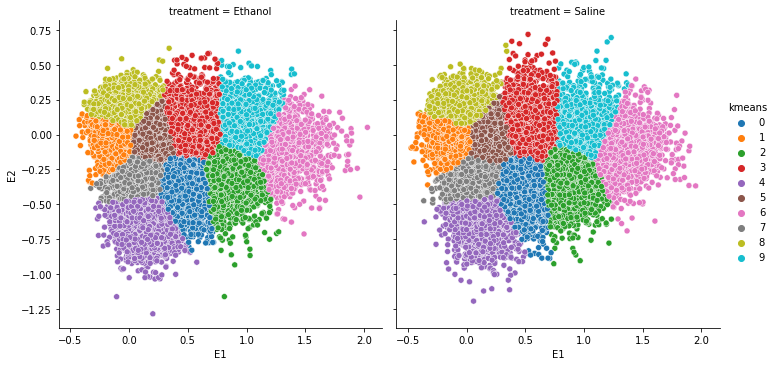

In [11]:
sns.relplot(x="E1", y="E2", hue="kmeans", col='treatment', data=output)